In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pymatgen.ext.matproj import MPRester
from matminer.featurizers.structure import OrbitalFieldMatrix
from multiprocessing import Pool
import pickle
import glob
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [5]:
mpr = MPRester("mv0hJgupKqxOTd9c")
df = pd.read_csv('totalxtrain.csv')
material_ids = df['material_id']
orbital_field_matrix_featurizer = OrbitalFieldMatrix(flatten=False)
all_features = []

c:\Users\shrey\anaconda3\lib\site-packages\pymatgen\ext\matproj.py:186: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(


In [15]:
start_index = 0

try:
    with open('features.pkl', 'rb') as f:
        all_features = pickle.load(f)
        start_index = len(all_features)
        print(f"Loaded features up to index {start_index}")

    for i in range(start_index, len(material_ids)):
        material_id = material_ids[i]
        structure = mpr.get_structure_by_material_id(material_id)
        features = orbital_field_matrix_featurizer.featurize(structure)
        all_features.append(features)

        if i % 100 == 0:
            with open('features.pkl', 'wb') as f:
                pickle.dump(all_features, f)
                print(f"Saved features up to index {i}")

except Exception as e:
    print("An error occurred:", str(e))
    print("Saving progress...")
    with open('features.pkl', 'wb') as f:
        pickle.dump(all_features, f)
        print(f"Saved features up to index {start_index}")

with open('features.pkl', 'wb') as f:
    pickle.dump(all_features, f)

print("Process completed.")

Loaded features up to index 8098
Process completed.


In [25]:
len(all_features)

8098

In [8]:
df_test = pd.read_csv('totalxtest.csv')
material_ids_test = df_test['material_id']
material_ids_test

0       mp-1188260
1         mp-12192
2        mp-558475
3       mp-1095492
4          mp-4661
           ...    
2020     mp-744567
2021      mp-12646
2022     mp-706444
2023     mp-696152
2024    mp-1179030
Name: material_id, Length: 2025, dtype: object

In [21]:
orbital_field_matrix_featurizer = OrbitalFieldMatrix(flatten=False)
all_features_test = []

for i in range(0, len(material_ids_test)):
    material_id_test = material_ids_test[i]
    structure = mpr.get_structure_by_material_id(material_id_test)
    features = orbital_field_matrix_featurizer.featurize(structure)
    all_features_test.append(features)

In [26]:
len(all_features_test)

2025

In [67]:
x = np.array(all_features)
X_train = [np.ravel(row) for row in x]
X_train = np.reshape(X_train,(8098,1024))

In [68]:
x_test = np.array(all_features_test)
X_test = [np.ravel(row) for row in x_test]
X_test = np.reshape(X_test,(2025,1024))

In [92]:
y = df['crystal_system']
y_test = df_test['crystal_system']
y[0]

'orthorhombic'

In [94]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(y)
word_index = tokenizer.word_index
print("Word Index:", word_index)
sequences = tokenizer.texts_to_sequences(y)

vector = np.array(sequences)
Y_train = keras.utils.to_categorical(
    vector-1, num_classes=7, dtype='float32'
)

Word Index: {'monoclinic': 1, 'orthorhombic': 2, 'tetragonal': 3, 'triclinic': 4, 'cubic': 5, 'trigonal': 6, 'hexagonal': 7}


In [95]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(y_test)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(y_test)

vector_test = np.array(sequences)
Y_test = keras.utils.to_categorical(
    vector_test-1, num_classes=7, dtype='float32'
)

In [112]:
ann = Sequential([
    Dense(units=1024, activation='relu', input_shape=(1024,)),
    Dense(units=512, activation='relu'),  
    Dense(units=256, activation='relu'),   
    Dense(units=128, activation='relu'),
    Dense(units=64, activation='relu'),   
    Dense(units=32, activation='relu'),   
    Dense(units=16, activation='relu'), 
    Dense(units=7, activation='softmax')
])

In [113]:
ann.compile(optimizer='adam', 
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

history = ann.fit(X_train, Y_train, epochs=100, validation_data=(X_test, Y_test))

Epoch 1/100
254/254 [==============================] - 10s 29ms/step - loss: 1.7184 - accuracy: 0.3360 - val_loss: 1.6608 - val_accuracy: 0.3486
Epoch 2/100
254/254 [==============================] - 7s 28ms/step - loss: 1.6425 - accuracy: 0.3613 - val_loss: 1.6468 - val_accuracy: 0.3600
Epoch 3/100
254/254 [==============================] - 7s 28ms/step - loss: 1.5885 - accuracy: 0.3902 - val_loss: 1.6025 - val_accuracy: 0.3956
Epoch 4/100
254/254 [==============================] - 7s 28ms/step - loss: 1.5431 - accuracy: 0.4078 - val_loss: 1.5621 - val_accuracy: 0.4025
Epoch 5/100
254/254 [==============================] - 7s 27ms/step - loss: 1.5060 - accuracy: 0.4207 - val_loss: 1.5907 - val_accuracy: 0.4079
Epoch 6/100
254/254 [==============================] - 7s 29ms/step - loss: 1.4727 - accuracy: 0.4301 - val_loss: 1.5177 - val_accuracy: 0.4138
Epoch 7/100
254/254 [==============================] - 7s 29ms/step - loss: 1.4484 - accuracy: 0.4375 - val_loss: 1.5034 - val_accuracy

In [114]:
ann.evaluate(X_test,Y_test)

64/64 [==============================] - 1s 12ms/step - loss: 3.1234 - accuracy: 0.4657


[3.123411178588867, 0.46567901968955994]

64/64 [==============================] - 1s 11ms/step


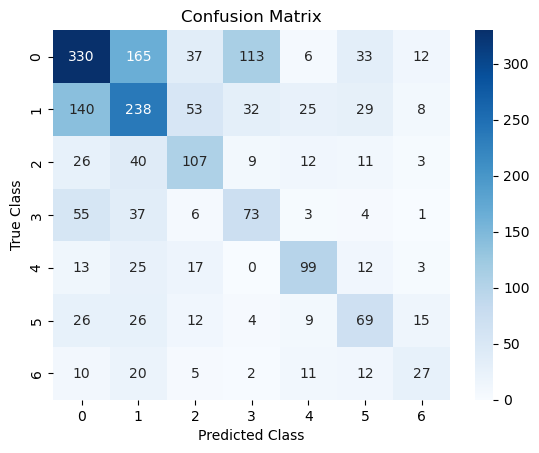

In [115]:
y_pred = ann.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)
y_test_classes = Y_test.argmax(axis=1)

conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()

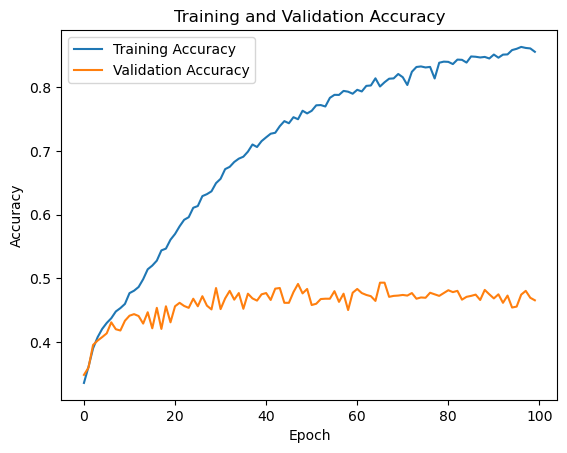

In [116]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()